# Initialization

In [1]:
%%python


# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

In [2]:
%%python

# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

In [3]:
%%python

import ROOT

OFFLINE_MAIN = os.getenv("OFFLINE_MAIN")
if OFFLINE_MAIN is not None:
    display(Markdown(f"via sPHENIX software distribution at `{OFFLINE_MAIN}`"))

via sPHENIX software distribution at `/cvmfs/sphenix.sdcc.bnl.gov/gcc-8.3/release/release_new/new.4`

In [4]:
%%cpp -d

// $Id: $

/*!
 * \file makeRAA_BUP2020.C
 * \brief 
 * \author Jin Huang <jhuang@bnl.gov>
 * \version $Revision:   $
 * \date $Date: $
 */

#include "sPhenixStyle.C"

#include <TChain.h>
#include <TCut.h>
#include <TEfficiency.h>
#include <TF1.h>
#include <TGraphAsymmErrors.h>
#include <TGraphErrors.h>
#include <TH2.h>
#include <TH3.h>
#include <TPolyLine.h>

#include <TFile.h>

#include <TColor.h>
#include <TLatex.h>
#include <TLegend.h>
#include <TLine.h>
#include <TStyle.h>

#include <TMath.h>
#include <TPad.h>
#include <TString.h>
#include <TTree.h>
#include <TVectorD.h>
#include <TVirtualFitter.h>

#include <cmath>
#include <iostream>

using namespace std;
// ROOT6 disabled assert. Well....
#ifdef assert
#undef assert
#endif
#define assert(exp)                                                                             \
  {                                                                                             \
    if (!(exp))                                                                                 \
    {                                                                                           \
      cout << "Assert (" << #exp << ") failed at " << __FILE__ << " line " << __LINE__ << endl; \
    }                                                                                           \
  }

In [5]:
SetsPhenixStyle();
gStyle->SetOptStat(0);
gStyle->SetOptFit(1111);
TVirtualFitter::SetDefaultFitter("Minuit2");

sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode


In [6]:
%%cpp -d



//! Service function to SaveCanvas()
void
SavePad(TPad * p)
{
  if (!p)
    return;

  TList * l = p->GetListOfPrimitives();
//  l->Print();

  TIter next(l);
  TObject *obj = NULL;
  while ((obj = next()))
    {

      if (obj->IsA()->GetBaseClassOffset(TClass::GetClass("TPad")) >= 0)
        {
          if ((TPad *) obj != p)
            SavePad((TPad *) obj);
        }
      else if (obj->IsA()->GetBaseClassOffset(TClass::GetClass("TH1")) >= 0)
        {
          cout << "Save TH1 " << obj->GetName() << endl;
          obj->Clone()->Write(obj->GetName(), TObject::kOverwrite);
        }
      else if (obj->IsA()->GetBaseClassOffset(TClass::GetClass("TF1")) >= 0)
        {
          cout << "Save TF1 " << obj->GetName() << endl;
          obj->Clone()->Write(obj->GetName(), TObject::kOverwrite);
        }
      else if (obj->IsA()->GetBaseClassOffset(TClass::GetClass("TGraph")) >= 0)
        {
          cout << "Save TGraph " << obj->GetName() << endl;
          obj->Clone()->Write(obj->GetName(), TObject::kOverwrite);
        }
      else if (obj->IsA()->GetBaseClassOffset(TClass::GetClass("TEfficiency")) >= 0)
        {
          cout << "Save TEfficiency " << obj->GetName() << endl;
          obj->Clone()->Write(obj->GetName(), TObject::kOverwrite);
        }
    }
}



//! Save canvas to multiple formats
/*!
 *  @param[in] c    pointer to the canvas
 *  @param[in] name Base of the file name. The default is the name of the cavas
 *  @param[in] bEPS true = save .eps and .pdf format too.
 */
void
SaveCanvas(TCanvas * c, TString name = "", Bool_t bEPS = kTRUE)
{
  if (name.Length() == 0)
    name = c->GetName();

  c->Print(name + ".png");

  TDirectory * oldd = gDirectory;

  TString rootfilename;

  c->Print(rootfilename = name + ".root");

  TFile f(rootfilename, "update");

  SavePad(c);

  f.Close();

  oldd->cd();

  if (bEPS)
    {
//      c->Print(name + ".pdf");

      float x = 20;
      float y = 20;
      gStyle->GetPaperSize(x, y);

      gStyle->SetPaperSize(c->GetWindowWidth() / 72 * 2.54,
          c->GetWindowHeight() / 72 * 2.54);
      c->Print(name + ".eps");
      c->Print(name + ".svg");
      gSystem->Exec("rsvg-convert -f pdf -o "+name + ".pdf " + name + ".svg");
      gSystem->Exec("rm -fv " +  name + ".svg");

      gStyle->SetPaperSize(x, y);
    }
    c->Print(name+".C");
}

In [7]:

//! Draw 1D histogram along with its reference as shade
//! @param[in] draw_href_error whether to draw error band for reference plot. Otherwise, it is a filled histogram (default)
double DrawReference(TH1 *hnew, TH1 *href, bool draw_href_error = false, bool do_kstest = false)
{
  hnew->SetLineColor(kBlue + 3);
  hnew->SetMarkerColor(kBlue + 3);
  //  hnew->SetLineWidth(2);
  hnew->SetMarkerStyle(kFullCircle);
  //  hnew->SetMarkerSize(1);

  if (href)
  {
    if (draw_href_error)
    {
      href->SetLineColor(kGreen + 1);
      href->SetFillColor(kGreen + 1);
      href->SetLineStyle(kSolid);
      href->SetMarkerColor(kGreen + 1);
      //      href->SetLineWidth(2);
      href->SetMarkerStyle(kDot);
      href->SetMarkerSize(0);
    }
    else
    {
      href->SetLineColor(kGreen + 1);
      href->SetFillColor(kGreen + 1);
      href->SetLineStyle(0);
      href->SetMarkerColor(kGreen + 1);
      href->SetLineWidth(0);
      href->SetMarkerStyle(kDot);
      href->SetMarkerSize(0);
    }
  }

  hnew->DrawClone();  // set scale

  double ks_test = numeric_limits<double>::signaling_NaN();

  if (href)
  {
    if (draw_href_error)
    {
      href->DrawClone("E2 same");
      href->SetFillStyle(0);
      href->SetLineWidth(8);
      href->DrawClone("HIST same ][");
    }
    else
      href->DrawClone("HIST same");
    hnew->DrawClone("same");  // over lay data points

    if (do_kstest)
      ks_test = hnew->KolmogorovTest(href, "");
  }

  // ---------------------------------
  // now, make summary header
  // ---------------------------------
  if (href)
  {
    gPad->SetTopMargin(.14);
    TLegend *legend = new TLegend(0, .93, 0, 1, hnew->GetTitle(), "NB NDC");
    legend->Draw();
    legend = new TLegend(0, .86, .4, .93, NULL, "NB NDC");
    legend->AddEntry(href, Form("Pyt8 BeamShape"), "f");
    legend->Draw();
    legend = new TLegend(0.4, .86, 1, .93, NULL, "NB NDC");

    if (do_kstest)
    {
      TLegendEntry *le = legend->AddEntry(hnew, Form("New: KS-Test P=%.3f", ks_test), "lpe");
      if (ks_test >= 1)
        le->SetTextColor(kBlue + 1);
      else if (ks_test >= .2)
        le->SetTextColor(kGreen + 2);
      else if (ks_test >= .05)
        le->SetTextColor(kYellow + 1);
      else
        le->SetTextColor(kRed + 1);
      legend->Draw();
    }
    else
    {
      TLegendEntry *le = legend->AddEntry(hnew, Form("Fun4All X-ing AfterBurner"), "lpe");
      legend->Draw();
    }
  }
  else
  {
    gPad->SetTopMargin(.07);
    TLegend *legend = new TLegend(0, .93, 0, 1, hnew->GetTitle(), "NB NDC");
    legend->Draw();
  }


  return ks_test;
}

# Inputs

In [8]:

// TFile * fpythia8_ref = TFile::Open("testCrossDivergence.hist.root");
TFile * fpythia8_ref = TFile::Open("testCrossDivergenceAllStable_hiDiv_18x275_25mRad.hist.root");
// TFile * ftrack_eval = TFile::Open("g4tracking_eval.root");
TFile * ftrack_eval = TFile::Open("testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root");

TString description ("25mrad crossing angle, CDR divergence, Crab kick");

## Input file check

In [9]:
assert(ftrack_eval->IsOpen());
ftrack_eval->ls();

TFile**		testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root	
 TFile*		testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root	
  KEY: TTree	tracks;13	FastSim Eval => tracks
  KEY: TTree	tracks;12	FastSim Eval => tracks
  KEY: TTree	vertex;1	FastSim Eval => vertces
  KEY: TH2D	DeltaMomVsTruthEta;1	#frac{#Delta p}{truth p} vs. truth #eta
  KEY: TH2D	DeltaMomVsTruthMom;1	#frac{#Delta p}{truth p} vs. truth p


In [10]:
TTree * tracks = (TTree *)( ftrack_eval->Get("tracks"));
assert(tracks);
tracks->Show(0);

======> EVENT:0
 event           = 1
 gtrackID        = 1
 gflavor         = -211
 gpx             = 0.00839496
 gpy             = -0.213907
 gpz             = 0.188549
 gvx             = 3.56894
 gvy             = -10.5158
 gvz             = 8.84709
 gvt             = 0.298177
 trackID         = -9999
 charge          = -9999
 nhits           = -9999
 px              = nan
 py              = nan
 pz              = nan
 pcax            = nan
 pcay            = nan
 pcaz            = nan
 dca2d           = nan


In [11]:
tracks->SetAlias("gpt","1*sqrt(gpx**2+gpy**2)");
tracks->SetAlias("gp","1*sqrt(gpx**2+gpy**2+gpz**2)");
tracks->SetAlias("gpphi","1*atan2(gpy,gpx)");
tracks->SetAlias("gpeta","0.5*log((gp + gpz)/(gp - gpz))");

## Ref file dump

In [12]:
fpythia8_ref->ls()


TFile**		testCrossDivergenceAllStable_hiDiv_18x275_25mRad.hist.root	
 TFile*		testCrossDivergenceAllStable_hiDiv_18x275_25mRad.hist.root	
  KEY: TH1D	q2Hist;1	Log Q2
  KEY: TH1D	yHist;1	Inelasticity
  KEY: TH2D	phaseSpaceHist;1	Log Q2 Vs Log x
  KEY: TH1D	eCM;1	Modified - Nominal CM Energy
  KEY: TH2D	pXY1;1	Hadron Beam Py Vs Px
  KEY: TH2D	pXZProd1;1	Hadron Beam Px Vs Vertex z
  KEY: TH2D	pYZProd1;1	Hadron Beam Py Vs Vertex z
  KEY: TH2D	pXY2;1	Lepton Beam Py Vs Px
  KEY: TH2D	pXZProd2;1	Lepton Beam Px Vs Vertex z
  KEY: TH2D	pYZProd2;1	Lepton Beam Py Vs Vertex z
  KEY: TH1D	pZ1;1	Hadron Beam Pz
  KEY: TH1D	pZ2;1	Lepton Beam Pz
  KEY: TH1D	atan2PxPz1;1	
  KEY: TH1D	atan2PyPz1;1	
  KEY: TH1D	atan2PyPtot1;1	
  KEY: TH1D	vtxX;1	Vertex x
  KEY: TH1D	vtxY;1	Vertex y
  KEY: TH1D	vtxZ;1	Vertex z
  KEY: TH1D	vtxT;1	Time
  KEY: TH2D	vtxYvsX;1	Vertex Y vs X
  KEY: TH2D	vtxXvsT;1	Vertex X vs T
  KEY: TH2D	vtxXvsZ;1	Vertex X vs Z
  KEY: TH2D	vtxYvsZ;1	Vertex Y vs Z
  KEY: TH2D	vtxTvsZ;1	Interacti

# Phi checks

## Phi Sum

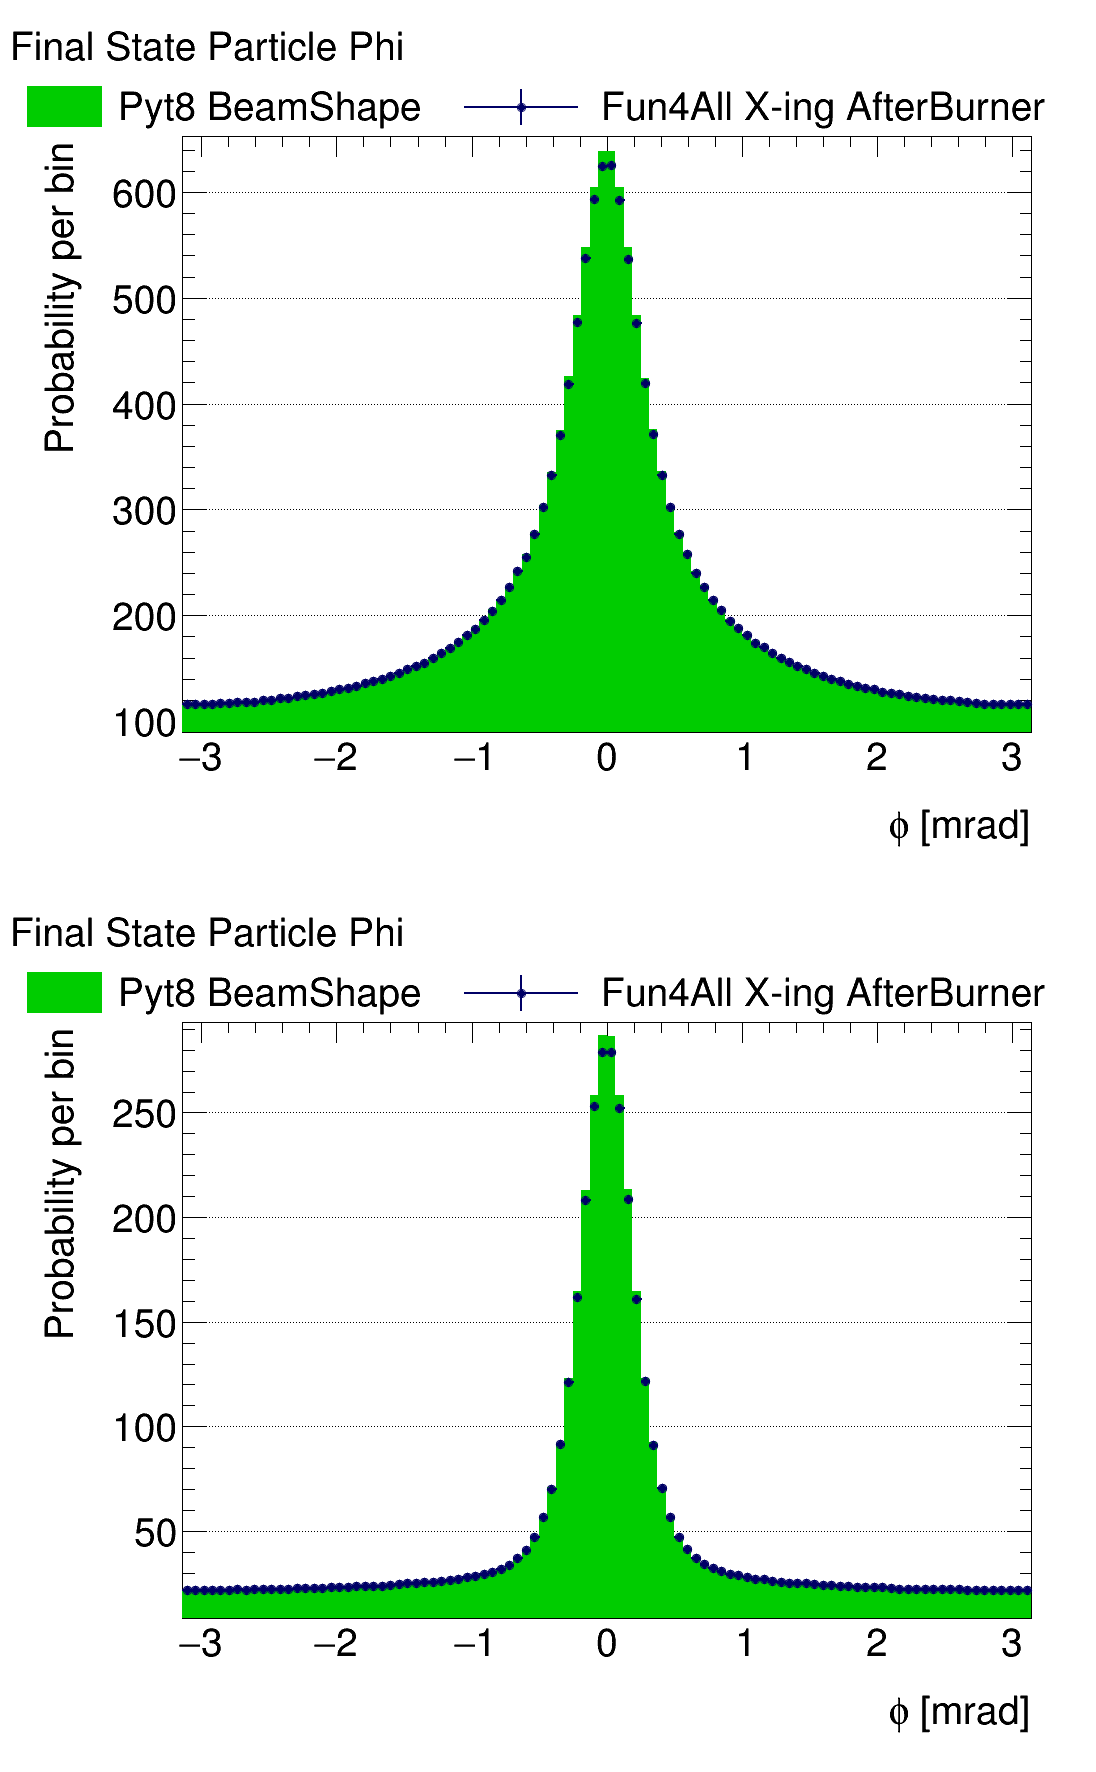

Save TH1 partPhi
Save TH1 partPhi
Save TH1 partPhi
Save TH1 partPhiHi
Save TH1 partPhiHi
Save TH1 partPhiHi
removed ‘testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partPhi.svg’


Info in <TCanvas::Print>: png file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partPhi.png has been created
Info in <TCanvas::SaveAs>: ROOT file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partPhi.root has been created
Info in <TCanvas::Print>: eps file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partPhi.eps has been created
Info in <TCanvas::Print>: SVG file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partPhi.svg has been created
Info in <TCanvas::SaveSource>: C++ Macro file: testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partPhi.C has been generated


In [13]:
{
    
    
    
    TCanvas *c1 = new TCanvas("partPhi" ,
                  "partPhi" , 1100, 1800);
    
     c1->Divide(1, 2);
      int idx = 1;
      TPad *p;

      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridy();
          
        TH1D *partPhiHist = new TH1D("partPhi","Final State Particle Phi;#phi [mrad];Probability per bin",100,-1.0*TMath::Pi(),TMath::Pi());
        tracks->Draw("gpphi>>partPhi","abs(gpeta)<10","goff");

        partPhiHist->Sumw2();
//         partPhiHist->Scale(1./partPhiHist->GetSum());

        TH1D *partPhiHist_ref  = (TH1D *)( fpythia8_ref->Get("partPhi"));
        assert(partPhiHist_ref);
        partPhiHist_ref->Sumw2();

//         partPhiHist_ref->Scale(1./partPhiHist_ref->GetSum());
    
          

        DrawReference(partPhiHist, partPhiHist_ref, false);
      }
    
      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridy();
          
        TH1D *partPhiHiHist  = new TH1D("partPhiHi","Final State Particle Phi;#phi [mrad];Probability per bin",100,-1.0*TMath::Pi(),TMath::Pi());
        tracks->Draw("gpphi>>partPhiHi","gpt>1 && abs(gpeta)<10","goff");

        partPhiHiHist ->Sumw2();
//         partPhiHiHist ->Scale(1./partPhiHiHist ->GetSum());
          

        TH1D *partPhiHiHist_ref  = (TH1D *)( fpythia8_ref->Get("partPhiHi"));
        assert(partPhiHiHist_ref);
        partPhiHiHist_ref->Sumw2();

//         partPhiHiHist_ref->Scale(1./partPhiHiHist_ref->GetSum());
    
          

        DrawReference(partPhiHiHist, partPhiHiHist_ref, false);
      }



    c1->Draw();
    SaveCanvas(c1, TString(ftrack_eval->GetName() )+"_"+ TString(c1->GetName()), kTRUE);
}

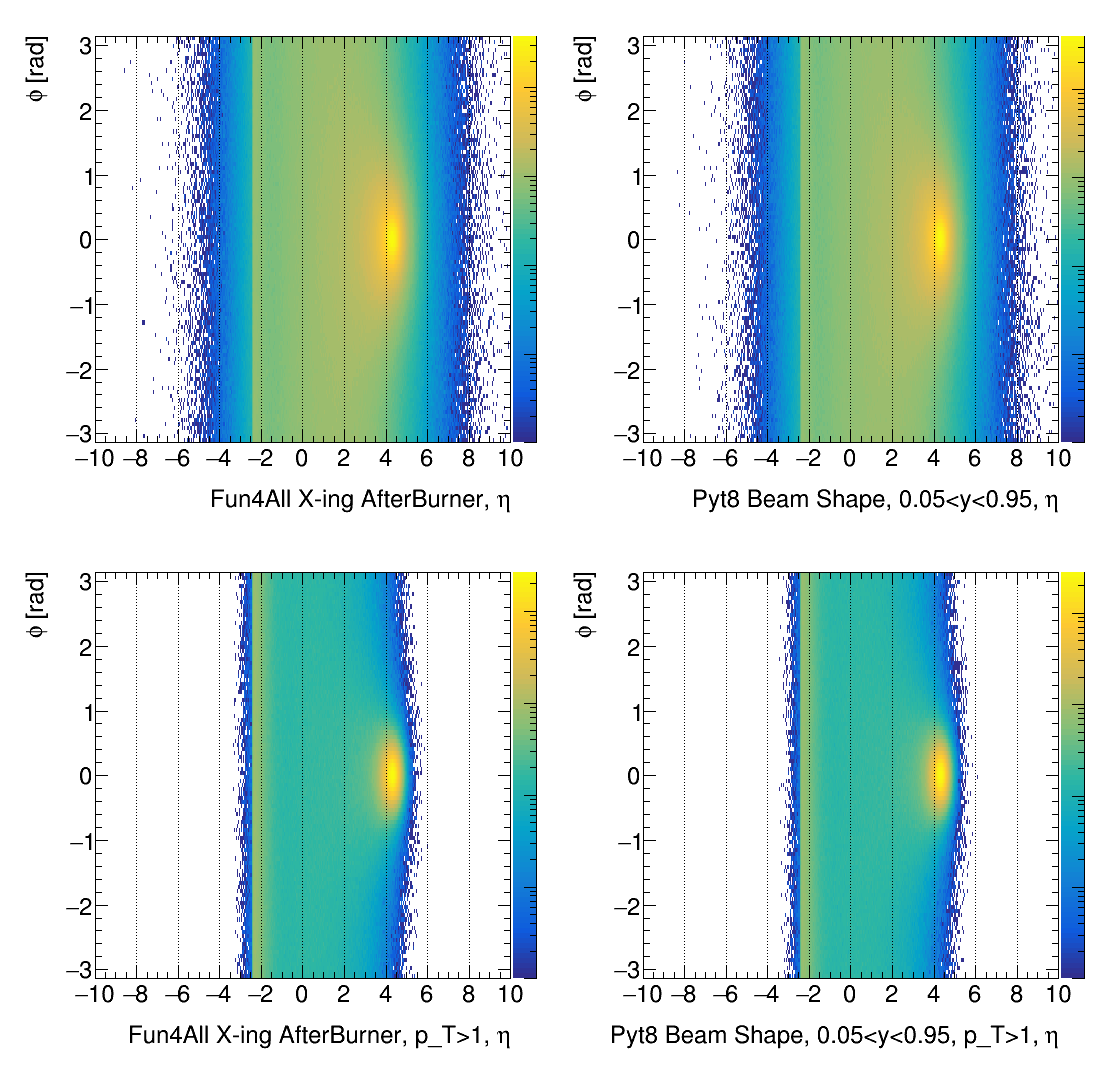

Save TH1 partPhiVsEta
Save TH1 partPhiVsEta
Save TH1 partPhiVsEtaHi
Save TH1 partPhiVsEtaHi
removed ‘testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partPhi.svg’


Warning in <TCanvas::Constructor>: Deleting canvas with same name: partPhi
Info in <TCanvas::Print>: png file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partPhi.png has been created
Info in <TCanvas::SaveAs>: ROOT file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partPhi.root has been created
Info in <TCanvas::Print>: eps file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partPhi.eps has been created
Info in <TCanvas::Print>: SVG file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partPhi.svg has been created
Info in <TCanvas::SaveSource>: C++ Macro file: testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partPhi.C has been generated


In [14]:
{
     TH2D *partPhiVsEtaHist = new TH2D("partPhiVsEta","Final State Particle Phi Vs Eta",400,-10.,10.,100,-1.0*TMath::Pi(),TMath::Pi());
     TH2D *partPhiVsEtaHiHist = new TH2D("partPhiVsEtaHi","Final State Particle Phi Vs Eta (Pt > 1 GeV)",400,-10.,10.,100,-1.0*TMath::Pi(),TMath::Pi());
    
    tracks->Draw("gpphi:gpeta>>partPhiVsEta","abs(gpeta)<10","goff");
    tracks->Draw("gpphi:gpeta>>partPhiVsEtaHi","gpt>1 && abs(gpeta)<10","goff");

    
    
    TH1D *partPhiVsEtaHist_ref  = (TH1D *)( fpythia8_ref->Get("partPhiVsEta"));
    assert(partPhiVsEtaHist_ref);    
    TH1D *partPhiVsEtaHiHist_ref  = (TH1D *)( fpythia8_ref->Get("partPhiVsEtaHi"));
    assert(partPhiVsEtaHiHist_ref);
    
    
    TCanvas *c1 = new TCanvas("partPhi" ,
                  "partPhi" , 1100, 1100);
    
     c1->Divide(2, 2);
      int idx = 1;
      TPad *p;

      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
        p->SetLogz();

          partPhiVsEtaHist->SetTitle(";Fun4All X-ing AfterBurner, #eta;#phi [rad]");
          partPhiVsEtaHist->Draw("colz");
          
      }
      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
        p->SetLogz();

          
          partPhiVsEtaHist_ref->SetTitle(";Pyt8 Beam Shape, 0.05<y<0.95, #eta;#phi [rad]");
          partPhiVsEtaHist_ref->Draw("colz");
          
      }
      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
        p->SetLogz();

          
          partPhiVsEtaHiHist->SetTitle(";Fun4All X-ing AfterBurner, p_T>1, #eta;#phi [rad]");
          partPhiVsEtaHiHist->Draw("colz");
          
      }
      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
        p->SetLogz();

          
          partPhiVsEtaHiHist_ref->SetTitle(";Pyt8 Beam Shape, 0.05<y<0.95, p_T>1, #eta;#phi [rad]");
          partPhiVsEtaHiHist_ref->Draw("colz");
          
      }



    c1->Draw();
    SaveCanvas(c1, TString(ftrack_eval->GetName() )+"_"+ TString(c1->GetName()), kTRUE);
}

# Eta ranges

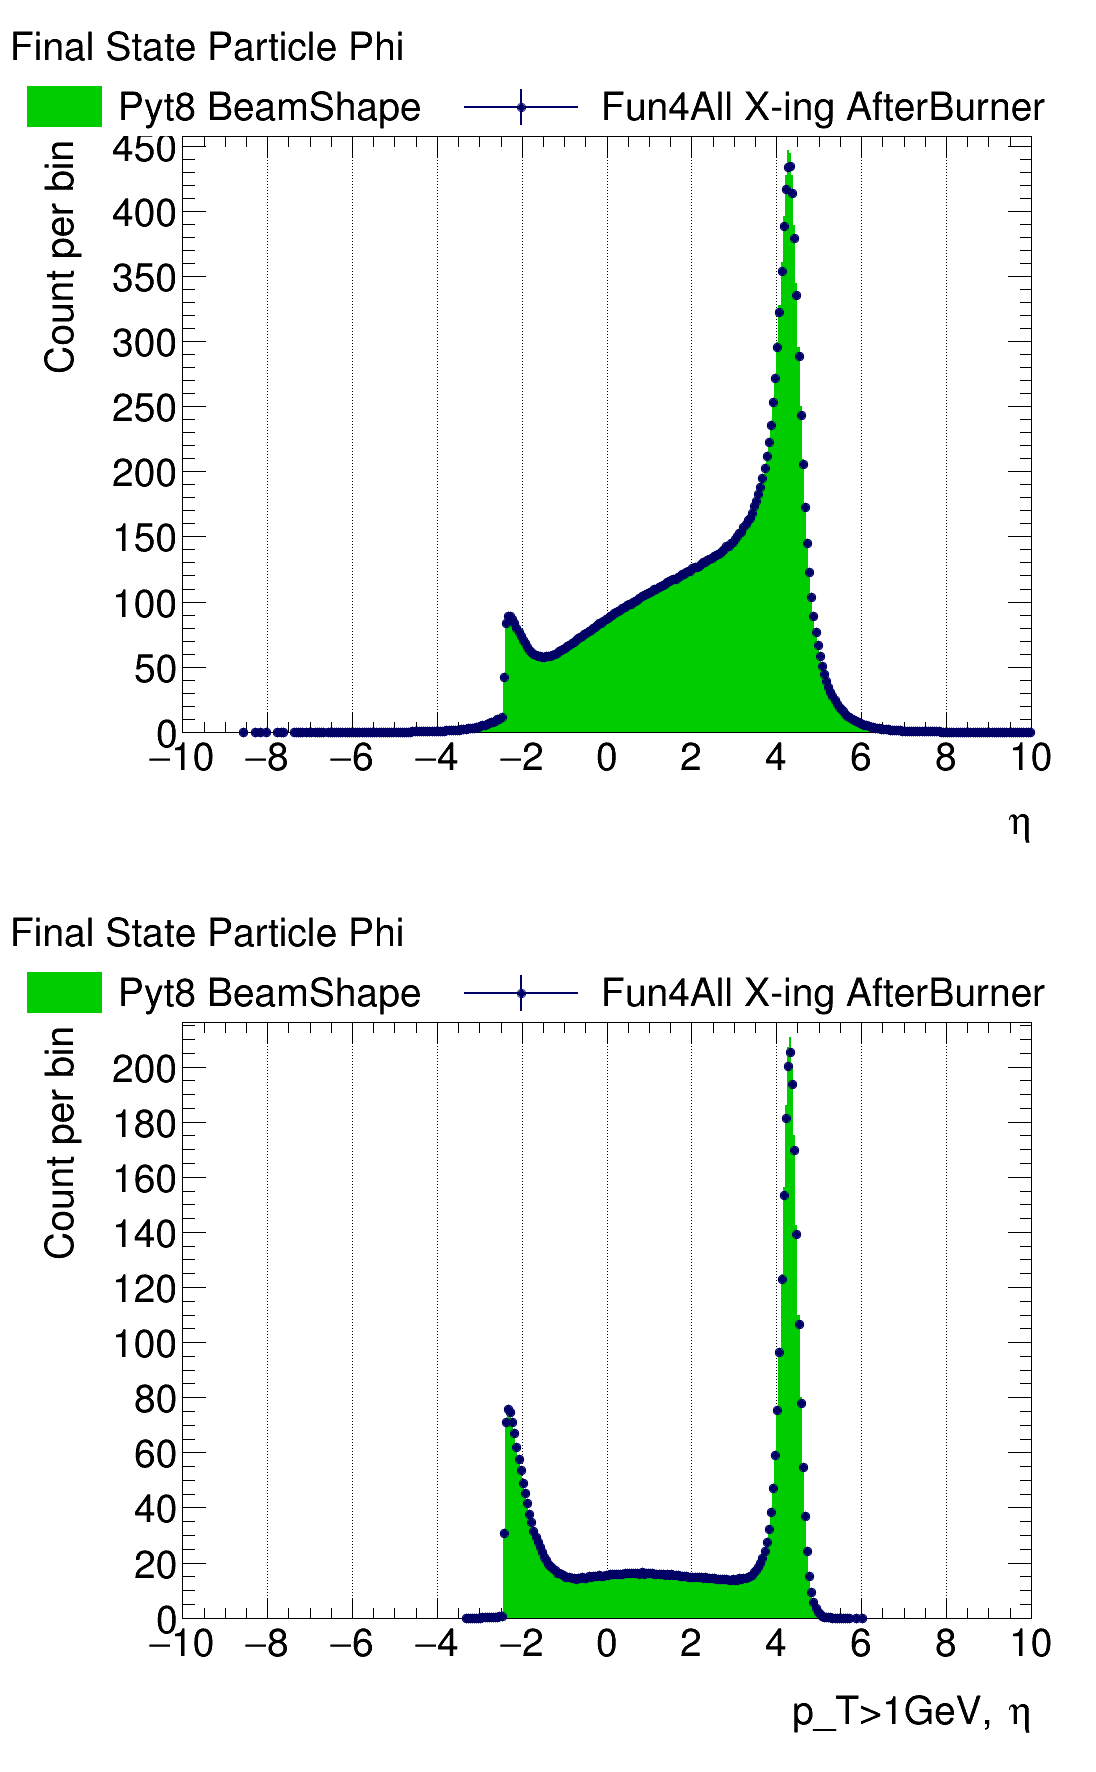

Save TH1 partEta
Save TH1 partEta
Save TH1 partEta
Save TH1 partEtaHi
Save TH1 partEtaHi
Save TH1 partEtaHi
removed ‘testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partEta.svg’


Info in <TCanvas::Print>: png file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partEta.png has been created
Info in <TCanvas::SaveAs>: ROOT file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partEta.root has been created
Info in <TCanvas::Print>: eps file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partEta.eps has been created
Info in <TCanvas::Print>: SVG file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partEta.svg has been created
Info in <TCanvas::SaveSource>: C++ Macro file: testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partEta.C has been generated


In [15]:
{
    
    
    
    TCanvas *c1 = new TCanvas("partEta" ,
                  "partEta" , 1100, 1800);
    
     c1->Divide(1, 2);
      int idx = 1;
      TPad *p;

      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
          
        TH1D *partEtaHist = new TH1D("partEta","Final State Particle Phi;#eta;Count per bin",400,-10.,10.);
        tracks->Draw("gpeta>>partEta","abs(gpeta)<10","goff");

        partEtaHist->Sumw2();
//         partEtaHist->Scale(1./partEtaHist->GetSum());

        TH1D *partEtaHist_ref  = (TH1D *)( fpythia8_ref->Get("partEta"));
        assert(partEtaHist_ref);
        partEtaHist_ref->Sumw2();

//         partEtaHist_ref->Scale(1./partEtaHist_ref->GetSum());
    
          

        DrawReference(partEtaHist, partEtaHist_ref, false);
      }
    
      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
          
        TH1D *partEtaHiHist  = new TH1D("partEtaHi","Final State Particle Phi;p_T>1GeV, #eta;Count per bin",400,-10.,10.);
        tracks->Draw("gpeta>>partEtaHi","gpt>1 && abs(gpeta)<10","goff");

        partEtaHiHist ->Sumw2();
//         partEtaHiHist ->Scale(1./partEtaHiHist ->GetSum());
          

        TH1D *partEtaHiHist_ref  = (TH1D *)( fpythia8_ref->Get("partEtaHi"));
        assert(partEtaHiHist_ref);
        partEtaHiHist_ref->Sumw2();

//         partEtaHiHist_ref->Scale(1./partEtaHiHist_ref->GetSum());
    
          

        DrawReference(partEtaHiHist, partEtaHiHist_ref, false);
      }



    c1->Draw();
    SaveCanvas(c1, TString(ftrack_eval->GetName() )+"_"+ TString(c1->GetName()), kTRUE);
}

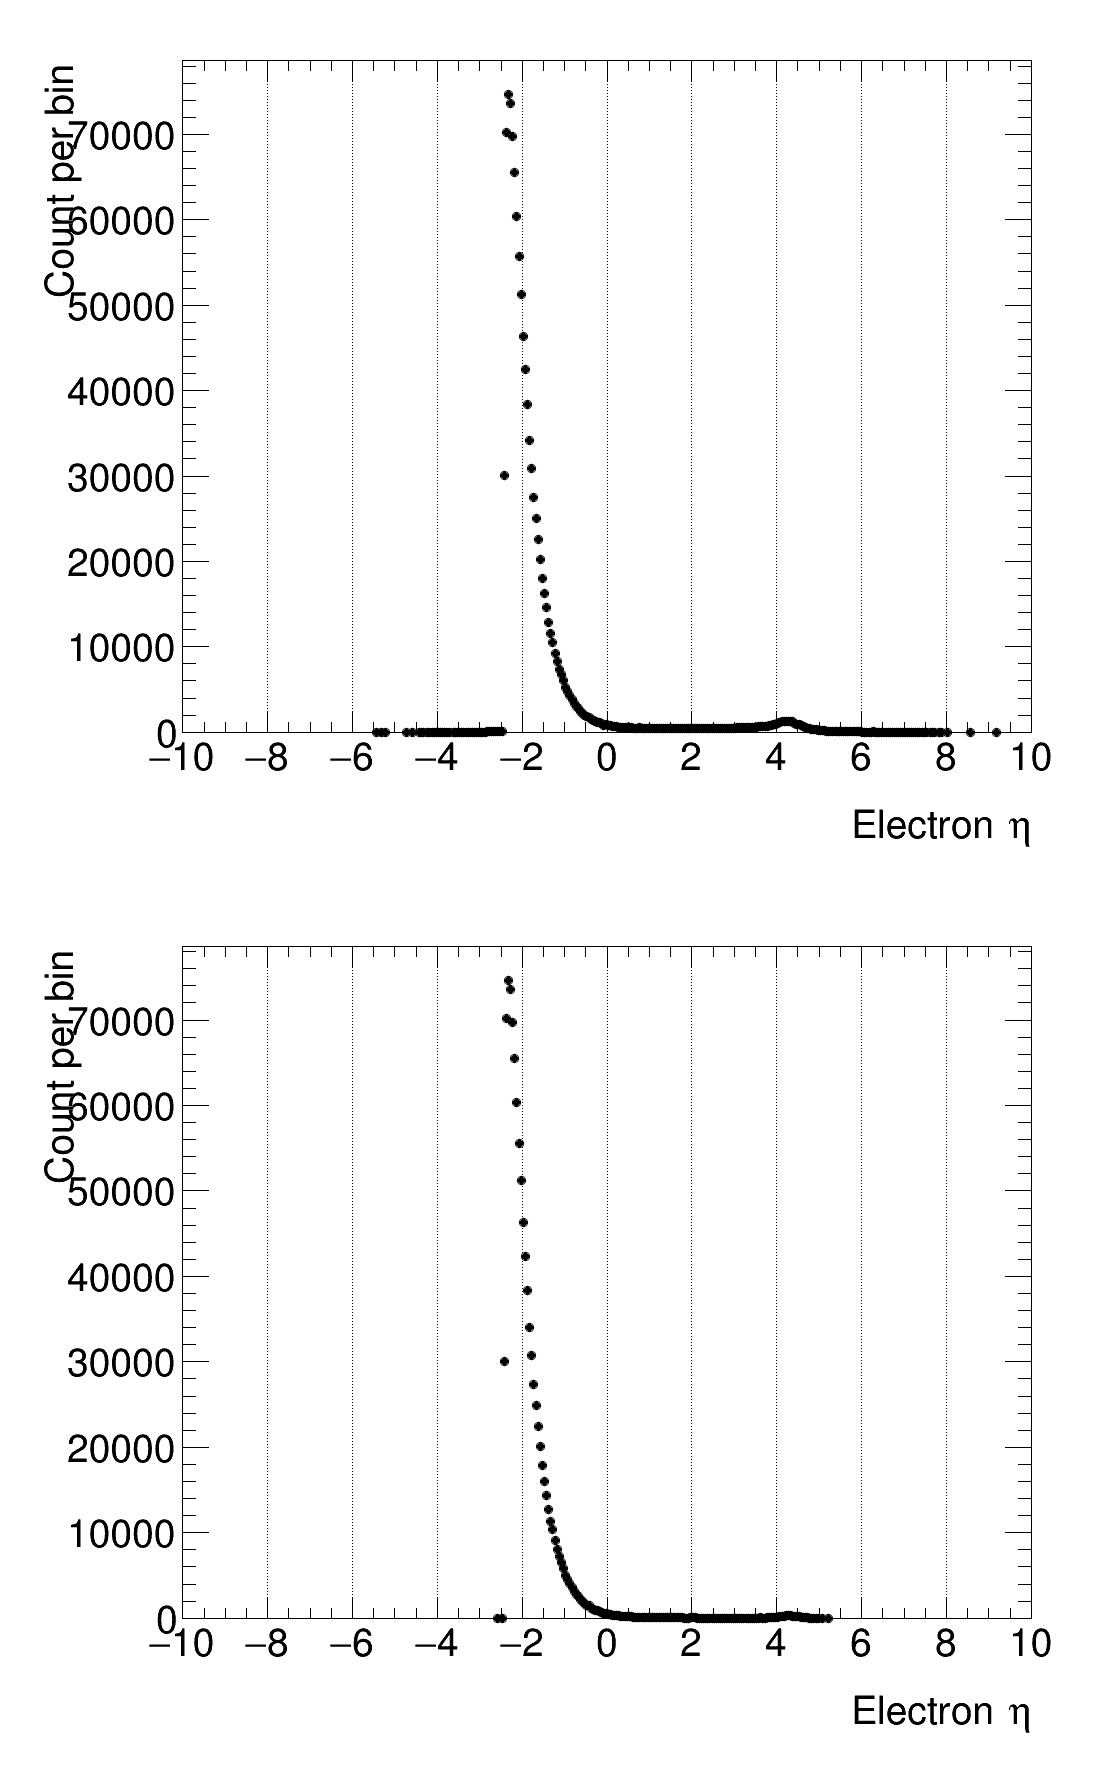

Save TH1 partEta
Save TH1 partEtaHi
removed ‘testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partEta_electron.svg’


Warning in <TFile::Append>: Replacing existing TH1: partEta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: partEta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: partEta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: partEta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: partEtaHi (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: partEtaHi (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: partEtaHi (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: partEtaHi (Potential memory leak).
Info in <TCanvas::Print>: png file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partEta_electron.png has been created
Info in <TCanvas::SaveAs>: ROOT file testNoEffectsAlterBeamEnergy.G4EICDetector.CrossDivergence.1000000_g4tracking_eval.root_partEta_electron.root has 

In [16]:
{
    
    
    
    TCanvas *c1 = new TCanvas("partEta_electron" ,
                  "partEta_electron" , 1100, 1800);
    
     c1->Divide(1, 2);
      int idx = 1;
      TPad *p;

      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
          
        TH1D *partEtaHist = new TH1D("partEta","Final State Particle Phi;Electron #eta;Count per bin",400,-10.,10.);
        tracks->Draw("gpeta>>partEta","abs(gpeta)<10 && gflavor==11","");

        partEtaHist->Sumw2();
//         partEtaHist->Scale(1./partEtaHist->GetSum());

      }
    
      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
          
        TH1D *partEtaHiHist  = new TH1D("partEtaHi","Final State Particle Phi;Electron #eta;Count per bin",400,-10.,10.);
        tracks->Draw("gpeta>>partEtaHi","gpt>1 && abs(gpeta)<10 && gflavor==11","");

        partEtaHiHist ->Sumw2();
      }



    c1->Draw();
    SaveCanvas(c1, TString(ftrack_eval->GetName() )+"_"+ TString(c1->GetName()), kTRUE);
}